<a href="https://colab.research.google.com/github/saichandrapandraju/Convolutional-Auto-Encoding-for-detecting-COVID/blob/main/covid_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!nvidia-smi

Wed Jul 28 14:23:50 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   73C    P8    33W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
from tqdm.notebook import tqdm_notebook
import tensorflow as tf
import zipfile
import glob
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns
import os
import random
import shutil

In [4]:
tf.random.set_seed(1)
random.seed(1)
np.random.seed(1)

In [5]:
!wget "https://storage.googleapis.com/cae_covid_classification/covid_normal_pneumonia.zip"

--2021-07-28 14:24:44--  https://storage.googleapis.com/cae_covid_classification/covid_normal_pneumonia.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.5.128, 74.125.206.128, 64.233.184.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.5.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 815753304 (778M) [application/x-zip-compressed]
Saving to: ‘covid_normal_pneumonia.zip’

covid_normal_pneumo 100%[===================>] 777.96M  41.2MB/s    in 20s     

2021-07-28 14:25:05 (38.6 MB/s) - ‘covid_normal_pneumonia.zip’ saved [815753304/815753304]



In [6]:
!unzip -q covid_normal_pneumonia.zip

In [7]:
total_covid = len(os.listdir('covid_normal_pneumonia/COVID/'))
total_normal = len(os.listdir('covid_normal_pneumonia/NORMAL/'))
total_pneumonia = len(os.listdir('covid_normal_pneumonia/PNEUMONIA/'))
print('covid_count : {} | normal_count : {} | pneumonia_count : {}'.format( str(total_covid),str(total_normal),str(total_pneumonia)) )

covid_count : 3709 | normal_count : 3700 | pneumonia_count : 3700


In [8]:
try:
    os.system("rm -rf ./split_data")
    os.mkdir('split_data')
    os.mkdir('split_data/train')
    os.mkdir('split_data/valid_test')
    os.mkdir('split_data/valid')
    os.mkdir('split_data/test')

    os.mkdir('split_data/train/COVID')
    os.mkdir('split_data/train/NORMAL')
    os.mkdir('split_data/train/PNEUMONIA')

    os.mkdir('split_data/valid_test/COVID')
    os.mkdir('split_data/valid_test/NORMAL')
    os.mkdir('split_data/valid_test/PNEUMONIA')

    os.mkdir('split_data/valid/COVID')
    os.mkdir('split_data/valid/NORMAL')
    os.mkdir('split_data/valid/PNEUMONIA')

    os.mkdir('split_data/test/COVID')
    os.mkdir('split_data/test/NORMAL')
    os.mkdir('split_data/test/PNEUMONIA')
    print('created directories')
except OSError as e:
    print('OS error occurred', e)

created directories


In [9]:
def split_data(source, training, testing, split_ratio):
  threshold = len(os.listdir(source)) * split_ratio
  flag = 0
  for i in random.sample(os.listdir(source), len(os.listdir(source))):
    flag += 1
    if flag <= threshold:
      if os.path.getsize(source + i) > 0:
        shutil.copyfile(source + i, training + i)
      else:
        print(source + i + " is zero length, so ignoring")
    else:
      if os.path.getsize(source + i) > 0:
        shutil.copyfile(source + i, testing + i)
      else:
        print(source + i + " is zero length, so ignoring")

In [10]:
COVID_SOURCE_DIR = 'covid_normal_pneumonia/COVID/'
NORMAL_SOURCE_DIR = 'covid_normal_pneumonia/NORMAL/'
PNEUMONIA_SOURCE_DIR = 'covid_normal_pneumonia/PNEUMONIA/'

TRAINING_COVID_DIR = 'split_data/train/COVID/'
VALID_TEST_COVID_DIR = 'split_data/valid_test/COVID/'
VALIDATING_COVID_DIR = 'split_data/valid/COVID/'
TESTING_COVID_DIR = 'split_data/test/COVID/'

TRAINING_NORMAL_DIR = 'split_data/train/NORMAL/'
VALID_TEST_NORMAL_DIR = 'split_data/valid_test/NORMAL/'
VALIDATING_NORMAL_DIR = 'split_data/valid/NORMAL/'
TESTING_NORMAL_DIR = 'split_data/test/NORMAL/'

TRAINING_PNEUMONIA_DIR = 'split_data/train/PNEUMONIA/'
VALID_TEST_PNEUMONIA_DIR = 'split_data/valid_test/PNEUMONIA/'
VALIDATING_PNEUMONIA_DIR = 'split_data/valid/PNEUMONIA/'
TESTING_PNEUMONIA_DIR = 'split_data/test/PNEUMONIA/'

In [11]:
split_data(COVID_SOURCE_DIR, TRAINING_COVID_DIR, VALID_TEST_COVID_DIR, 0.729)
split_data(VALID_TEST_COVID_DIR, VALIDATING_COVID_DIR, TESTING_COVID_DIR, 0.5)

In [12]:
tr_c = len(os.listdir(TRAINING_COVID_DIR))
vl_c = len(os.listdir(VALIDATING_COVID_DIR))
tst_c = len(os.listdir(TESTING_COVID_DIR))
print('covid_train count : {} | covid_valid count : {} | covid_test count : {}'.format( str(tr_c),str(vl_c),str(tst_c)) )

covid_train count : 2703 | covid_valid count : 503 | covid_test count : 503


In [13]:
split_data(NORMAL_SOURCE_DIR, TRAINING_NORMAL_DIR, VALID_TEST_NORMAL_DIR, 0.729)
split_data(VALID_TEST_NORMAL_DIR, VALIDATING_NORMAL_DIR, TESTING_NORMAL_DIR, 0.5)

In [14]:
tr_n = len(os.listdir(TRAINING_NORMAL_DIR))
vl_n = len(os.listdir(VALIDATING_NORMAL_DIR))
tst_n = len(os.listdir(TESTING_NORMAL_DIR))
print('normal_train count : {} | normal_valid count : {} | normal_test count : {}'.format( str(tr_n),str(vl_n),str(tst_n)) )

normal_train count : 2697 | normal_valid count : 501 | normal_test count : 502


In [15]:
split_data(PNEUMONIA_SOURCE_DIR, TRAINING_PNEUMONIA_DIR, VALID_TEST_PNEUMONIA_DIR, 0.729)
split_data(VALID_TEST_PNEUMONIA_DIR, VALIDATING_PNEUMONIA_DIR, TESTING_PNEUMONIA_DIR, 0.5)

In [16]:
tr_p = len(os.listdir(TRAINING_PNEUMONIA_DIR))
vl_p = len(os.listdir(VALIDATING_PNEUMONIA_DIR))
tst_p = len(os.listdir(TESTING_PNEUMONIA_DIR))
print('pneumonia_train count : {} | pneumonia_valid count : {} | pneumonia_test count : {}'.format( str(tr_p),str(vl_p),str(tst_p)) )

pneumonia_train count : 2697 | pneumonia_valid count : 501 | pneumonia_test count : 502


In [17]:
TRAINING_DIR = 'split_data/train/'
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1 / 255.0)
train_generator = train_datagen.flow_from_directory(TRAINING_DIR,
                                                    target_size=(224, 224),
                                                    class_mode='categorical',
                                                    shuffle=True,
                                                    batch_size=16)

VALIDATING_DIR = 'split_data/valid/'
valid_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1 / 255.0)
valid_generator = valid_datagen.flow_from_directory(VALIDATING_DIR,
                                                    target_size=(224, 224),
                                                    class_mode='categorical',
                                                    shuffle=False,
                                                    batch_size=16)

Found 8097 images belonging to 3 classes.
Found 1505 images belonging to 3 classes.


In [18]:
cae_model = tf.keras.models.load_model('/content/drive/MyDrive/pretrain_cae/cae.h5')

In [19]:
for layer in cae_model.layers[0].layers:
  layer.trainable = False

In [20]:
for batch, label in train_generator:
  print(batch.shape)
   # values should be in `[0,1]`.
  print(np.min(batch[0]), np.max(batch[0]))
  break


(16, 224, 224, 3)
0.0 1.0


In [21]:
enc_out = cae_model.layers[0].output

In [22]:
y = tf.keras.layers.Reshape((49,512))(enc_out)
y = tf.keras.layers.LSTM(512, return_sequences=True)(y)
y = tf.keras.layers.Flatten()(y)
y = tf.keras.layers.Dense(64, activation='relu')(y)
y = tf.keras.layers.Dense(3, activation='softmax')(y)

In [23]:
classification = tf.keras.Model(cae_model.layers[0].input, y)

In [24]:
classification.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 224, 224, 64)      1792      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 224, 224, 64)      36928     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 64)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 112, 112, 128)     73856     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 56, 56, 256)       295168

In [25]:
classification.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [26]:
early_stopping_cb = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, mode='auto')

In [27]:
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint('/content/drive/MyDrive/covid_classification/covid_classification.h5', save_best_only=True)

In [28]:
epochs = 20

In [29]:
history = classification.fit(train_generator,
                             epochs=epochs,
                             validation_data=valid_generator,
                             callbacks=[early_stopping_cb, checkpoint_cb])

Epoch 1/20
507/507 [==============================] - 96s 124ms/step - loss: 0.3463 - accuracy: 0.8539 - val_loss: 0.2020 - val_accuracy: 0.9316
Epoch 2/20
507/507 [==============================] - 62s 122ms/step - loss: 0.1601 - accuracy: 0.9402 - val_loss: 0.1361 - val_accuracy: 0.9535
Epoch 3/20
507/507 [==============================] - 62s 123ms/step - loss: 0.1101 - accuracy: 0.9616 - val_loss: 0.1081 - val_accuracy: 0.9628
Epoch 4/20
507/507 [==============================] - 63s 124ms/step - loss: 0.0928 - accuracy: 0.9667 - val_loss: 0.1276 - val_accuracy: 0.9502
Epoch 5/20
507/507 [==============================] - 62s 123ms/step - loss: 0.0659 - accuracy: 0.9774 - val_loss: 0.1217 - val_accuracy: 0.9581
Epoch 6/20
507/507 [==============================] - 62s 122ms/step - loss: 0.0556 - accuracy: 0.9810 - val_loss: 0.1283 - val_accuracy: 0.9588
Epoch 7/20
507/507 [==============================] - 62s 122ms/step - loss: 0.0446 - accuracy: 0.9843 - val_loss: 0.0935 - val_ac

In [30]:
history.history

{'accuracy': [0.8538964986801147,
  0.9402247667312622,
  0.9615907073020935,
  0.9666543006896973,
  0.9773990511894226,
  0.980980634689331,
  0.9843151569366455,
  0.9907373189926147,
  0.987896740436554,
  0.9904903173446655,
  0.9945659041404724,
  0.9948129057884216],
 'loss': [0.3463418185710907,
  0.16013020277023315,
  0.11011523753404617,
  0.09283505380153656,
  0.06586086750030518,
  0.05556926876306534,
  0.04464702308177948,
  0.02927277982234955,
  0.03030536137521267,
  0.02553548663854599,
  0.016210051253437996,
  0.014410680159926414],
 'val_accuracy': [0.9315614700317383,
  0.9534883499145508,
  0.9627906680107117,
  0.9501661062240601,
  0.9581395387649536,
  0.9588040113449097,
  0.9674418568611145,
  0.9667773842811584,
  0.9641196131706238,
  0.9647840261459351,
  0.9641196131706238,
  0.9667773842811584],
 'val_loss': [0.20199859142303467,
  0.13606096804141998,
  0.10811160504817963,
  0.12756815552711487,
  0.12167493999004364,
  0.12825720012187958,
  0.0934

In [31]:
classification = tf.keras.models.load_model('/content/drive/MyDrive/covid_classification/covid_classification.h5')  ## load best model

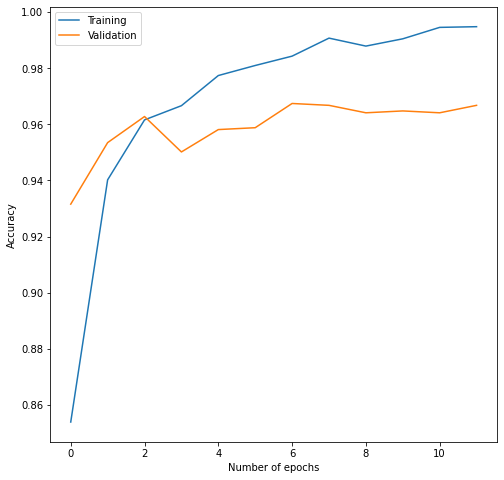

In [35]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(8, 8))
# plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training')
plt.plot(epochs_range, val_acc, label='Validation')
plt.legend(loc='best')
plt.xlabel('Number of epochs')
plt.ylabel('Accuracy')
plt.savefig('/content/drive/MyDrive/covid_classification/accuracy.png', dpi=300)
plt.show()

# plt.subplot(1, 2, 2)

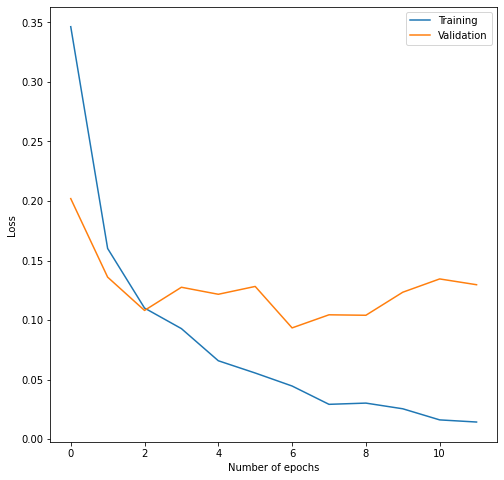

In [36]:
plt.figure(figsize=(8, 8))
plt.plot(epochs_range, loss, label='Training')
plt.plot(epochs_range, val_loss, label='Validation')
plt.legend(loc='best')
plt.xlabel('Number of epochs')
plt.ylabel('Loss')
plt.savefig('/content/drive/MyDrive/covid_classification/loss.png', dpi=300)
plt.show()

In [37]:
for i in classification.layers:
  i.trainable=True

In [38]:
classification.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

In [39]:
history_unfreeze = classification.fit(train_generator,
                              epochs=epochs,
                              validation_data=valid_generator,
                              callbacks=[early_stopping_cb, checkpoint_cb])

Epoch 1/20
507/507 [==============================] - 131s 248ms/step - loss: 0.0146 - accuracy: 0.9959 - val_loss: 0.0836 - val_accuracy: 0.9754
Epoch 2/20
507/507 [==============================] - 125s 247ms/step - loss: 0.0077 - accuracy: 0.9988 - val_loss: 0.0876 - val_accuracy: 0.9748
Epoch 3/20
507/507 [==============================] - 125s 246ms/step - loss: 0.0051 - accuracy: 0.9990 - val_loss: 0.0914 - val_accuracy: 0.9748
Epoch 4/20
507/507 [==============================] - 125s 246ms/step - loss: 0.0029 - accuracy: 0.9999 - val_loss: 0.0976 - val_accuracy: 0.9741
Epoch 5/20
507/507 [==============================] - 125s 246ms/step - loss: 0.0018 - accuracy: 0.9999 - val_loss: 0.1086 - val_accuracy: 0.9734
Epoch 6/20
507/507 [==============================] - 125s 246ms/step - loss: 0.0012 - accuracy: 1.0000 - val_loss: 0.1084 - val_accuracy: 0.9741


In [40]:
history_unfreeze.history

{'accuracy': [0.9959244132041931,
  0.9987649917602539,
  0.9990119934082031,
  0.9998764991760254,
  0.9998764991760254,
  1.0],
 'loss': [0.014621119946241379,
  0.007722055073827505,
  0.005074790678918362,
  0.0029331627301871777,
  0.0018061388982459903,
  0.0011915949871763587],
 'val_accuracy': [0.9754152894020081,
  0.974750816822052,
  0.974750816822052,
  0.9740864038467407,
  0.9734219312667847,
  0.9740864038467407],
 'val_loss': [0.08355965465307236,
  0.08761017769575119,
  0.09140530973672867,
  0.09757844358682632,
  0.1085851863026619,
  0.10841714590787888]}

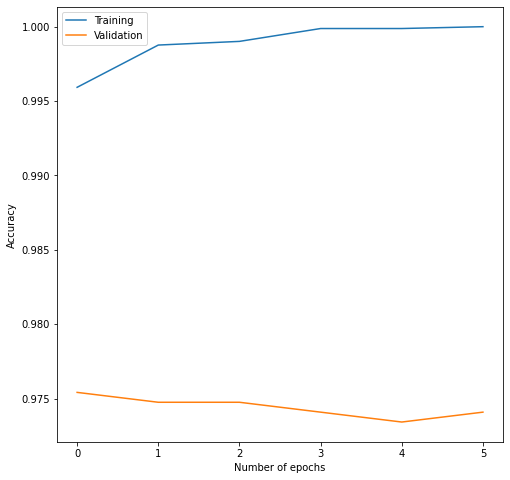

In [42]:
acc = history_unfreeze.history['accuracy']
val_acc = history_unfreeze.history['val_accuracy']

loss = history_unfreeze.history['loss']
val_loss = history_unfreeze.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(8, 8))
# plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training')
plt.plot(epochs_range, val_acc, label='Validation')
plt.legend(loc='best')
plt.xlabel('Number of epochs')
plt.ylabel('Accuracy')
plt.savefig('/content/drive/MyDrive/covid_classification/accuracy_unfreeze.png', dpi=300)
plt.show()

# plt.subplot(1, 2, 2)

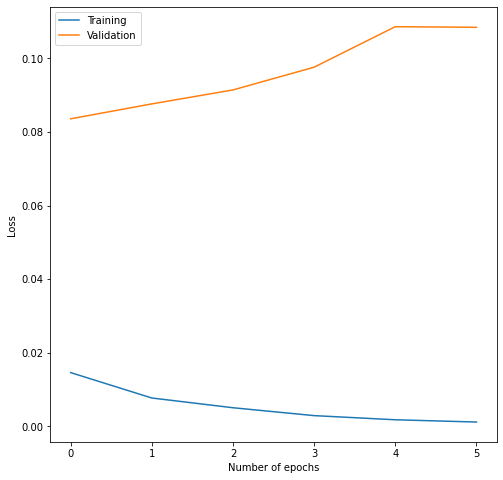

In [43]:
plt.figure(figsize=(8, 8))
plt.plot(epochs_range, loss, label='Training')
plt.plot(epochs_range, val_loss, label='Validation')
plt.legend(loc='best')
plt.xlabel('Number of epochs')
plt.ylabel('Loss')
plt.savefig('/content/drive/MyDrive/covid_classification/loss_unfreeze.png', dpi=300)
plt.show()

In [45]:
train_loss = history.history['loss']+history_unfreeze.history['loss']

In [46]:
train_acc = history.history['accuracy']+history_unfreeze.history['accuracy']

In [47]:
val_loss = history.history['val_loss']+history_unfreeze.history['val_loss']

In [48]:
val_acc = history.history['val_accuracy']+history_unfreeze.history['val_accuracy']

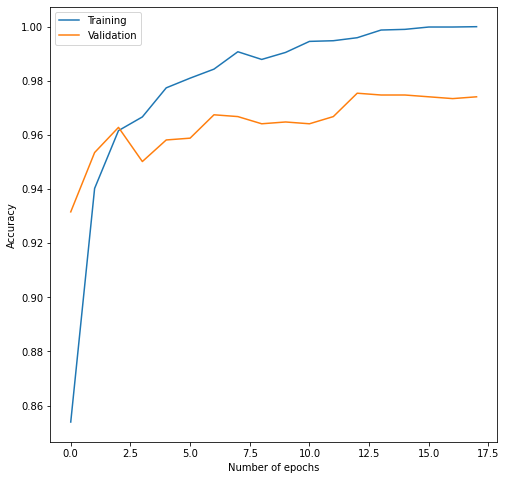

In [49]:
epochs_range = range(len(train_loss))

plt.figure(figsize=(8, 8))
# plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_acc, label='Training')
plt.plot(epochs_range, val_acc, label='Validation')
plt.legend(loc='best')
plt.xlabel('Number of epochs')
plt.ylabel('Accuracy')
plt.savefig('/content/drive/MyDrive/covid_classification/accuracy_overall.png', dpi=300)
plt.show()

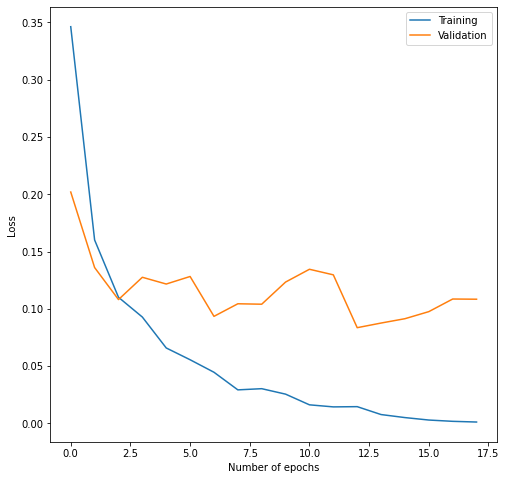

In [50]:
plt.figure(figsize=(8, 8))
plt.plot(epochs_range, train_loss, label='Training')
plt.plot(epochs_range, val_loss, label='Validation')
plt.legend(loc='best')
plt.xlabel('Number of epochs')
plt.ylabel('Loss')
plt.savefig('/content/drive/MyDrive/covid_classification/loss_overall.png', dpi=300)
plt.show()

# TESTING 

In [51]:
TESING_DIR = 'split_data/test/'
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1 / 255.0)
test_generator = test_datagen.flow_from_directory(TESING_DIR,
                                                    target_size=(224, 224),
                                                    class_mode='categorical',
                                                    shuffle=False,
                                                    batch_size=32)

Found 1507 images belonging to 3 classes.


In [52]:
predictions = classification.predict(test_generator)

In [53]:
predictions.shape

(1507, 3)

In [54]:
predicted_classes = np.argmax(predictions, axis=-1)
min(predicted_classes),max(predicted_classes)  ## must be 0,2

(0, 2)

In [55]:
test_generator.class_indices

{'COVID': 0, 'NORMAL': 1, 'PNEUMONIA': 2}

In [56]:
test_generator.classes

array([0, 0, 0, ..., 2, 2, 2], dtype=int32)

In [57]:
labels = test_generator.classes

In [58]:
class_names = list(test_generator.class_indices.keys())
class_names

['COVID', 'NORMAL', 'PNEUMONIA']

In [59]:
classification_report = metrics.classification_report(labels, predicted_classes, target_names=class_names)
print(classification_report)

              precision    recall  f1-score   support

       COVID       0.98      0.98      0.98       503
      NORMAL       0.97      0.98      0.97       502
   PNEUMONIA       0.99      0.98      0.98       502

    accuracy                           0.98      1507
   macro avg       0.98      0.98      0.98      1507
weighted avg       0.98      0.98      0.98      1507



In [60]:
cm_test = metrics.confusion_matrix(labels, predicted_classes)
cm_test

array([[494,   8,   1],
       [  7, 490,   5],
       [  4,   6, 492]])

In [61]:
def make_confusion_matrix(cf,
                          group_names=None,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='YlGnBu',
                          title=None,
                          save_dir=None):
    
    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])


    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        #Accuracy is sum of diagonal divided by total observations
        accuracy  = np.trace(cf) / float(np.sum(cf))

        #if it is a binary confusion matrix, show some more stats
        if len(cf)==2:
            #Metrics for Binary Confusion Matrices
            precision = cf[1,1] / sum(cf[:,1])
            recall    = cf[1,1] / sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
                accuracy,precision,recall,f1_score)
        else:
            stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""


    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False


    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    hmap = sns.heatmap(cf,annot=box_labels,fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories)
    hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
    hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=90, ha='right')

    if xyplotlabels:
        plt.ylabel('True label')
        plt.xlabel('Predicted label' + stats_text)
    else:
        plt.xlabel(stats_text)
    
    if title:
        plt.title(title)
    if save_dir:
      plt.savefig(save_dir, dpi=300)

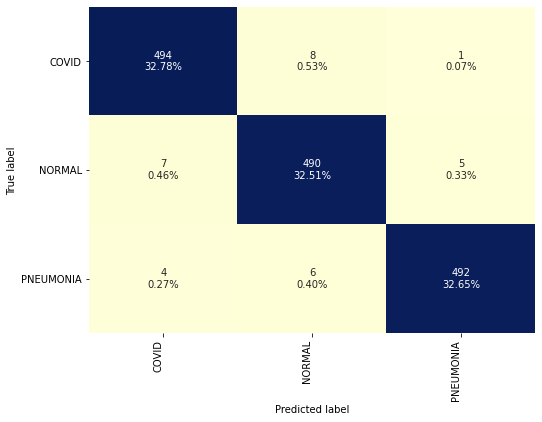

In [62]:
make_confusion_matrix(cm_test, figsize=(8,6), cbar=False, categories=class_names, save_dir='/content/drive/MyDrive/covid_classification/cm.png', sum_stats=False)

ROC AUC score: 0.9845709969763915 



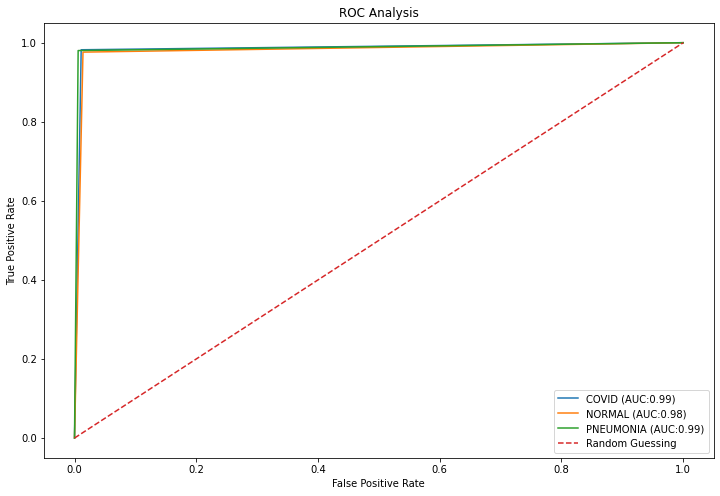

In [63]:
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve, auc, roc_auc_score


# set plot figure size
fig, c_ax = plt.subplots(1,1, figsize = (12, 8))

# function for scoring roc auc score for multi-class
def multiclass_roc_auc_score(y_test, y_pred, average="macro"):
    lb = LabelBinarizer()
    lb.fit(y_test)
    y_test = lb.transform(y_test)
    y_pred = lb.transform(y_pred)

    for (idx, c_label) in enumerate(class_names):
        fpr, tpr, thresholds = roc_curve(y_test[:,idx].astype(int), y_pred[:,idx])
        c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
    c_ax.plot(fpr, fpr, '--', label = 'Random Guessing')
    return roc_auc_score(y_test, y_pred, average=average)


print(f'ROC AUC score: {multiclass_roc_auc_score(labels, predicted_classes)} \n')

c_ax.legend()
c_ax.set_title('ROC Analysis')
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')
plt.savefig('/content/drive/MyDrive/covid_classification/roc.png', dpi=300)
plt.show()


In [64]:
print(f'metric name : [COVID, NORMAL, PNEUMONIA]')
FP = cm_test.sum(axis=0) - np.diag(cm_test) 
FN = cm_test.sum(axis=1) - np.diag(cm_test)
TP = np.diag(cm_test)
TN = cm_test.sum() - (FP + FN + TP)
FP = FP.astype(float)
FN = FN.astype(float)
TP = TP.astype(float)
TN = TN.astype(float)
print(f'False Positives: {FP}')
print(f'False Negatives: {FN}')
print(f'True Positives: {TP}')
print(f'True Negatives: {TN}')

# Sensitivity, hit rate, recall, or true positive rate
TPR = TP/(TP+FN)
print(f'Sensitivity, hit rate, recall, or true positive rate : {TPR}')
# Specificity or true negative rate
TNR = TN/(TN+FP) 
print(f'Specificity or true negative rate : {TNR}')
# Precision or positive predictive value
PPV = TP/(TP+FP)
print(f'Precision or positive predictive value : {PPV}')
# Negative predictive value
NPV = TN/(TN+FN)
print(f'Negative predictive value : {NPV}')
# Fall out or false positive rate
FPR = FP/(FP+TN)
print(f'Fall out or false positive rate : {FPR}')
# False negative rate
FNR = FN/(TP+FN)
print(f'False negative rate : {FNR}')
# False discovery rate
FDR = FP/(TP+FP)
print(f'False discovery rate : {FDR}')
# Overall accuracy for each class
ACC = (TP+TN)/(TP+FP+FN+TN)
print(f'Overall accuracy for each class : {ACC}')

metric name : [COVID, NORMAL, PNEUMONIA]
False Positives: [11. 14.  6.]
False Negatives: [ 9. 12. 10.]
True Positives: [494. 490. 492.]
True Negatives: [993. 991. 999.]
Sensitivity, hit rate, recall, or true positive rate : [0.98210736 0.97609562 0.98007968]
Specificity or true negative rate : [0.98904382 0.98606965 0.99402985]
Precision or positive predictive value : [0.97821782 0.97222222 0.98795181]
Negative predictive value : [0.99101796 0.98803589 0.9900892 ]
Fall out or false positive rate : [0.01095618 0.01393035 0.00597015]
False negative rate : [0.01789264 0.02390438 0.01992032]
False discovery rate : [0.02178218 0.02777778 0.01204819]
Overall accuracy for each class : [0.9867286  0.98274718 0.98938288]


In [66]:
sum(ACC)/3

0.9862862198628622

In [65]:
# img = keras.preprocessing.image.load_img(
#     img_path, target_size=(img_height, img_width)
# )
# img_array = keras.preprocessing.image.img_to_array(img)
# img_array = tf.expand_dims(img_array, 0) # Create a batch

# predictions = model.predict(img_array)
# score = tf.nn.softmax(predictions[0])

# print(
#     "This image most likely belongs to {} with a {:.2f} percent confidence."
#     .format(class_names[np.argmax(score)], 100 * np.max(score))
# )